In [5]:
# %%
import os
import sys
import json
import time
import random
from typing import Tuple, Dict, Any, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split  # (kept if utils uses it)
from sklearn.preprocessing import MinMaxScaler         # (kept if utils uses it)
from sklearn.metrics import confusion_matrix

from qiskit import QuantumCircuit
from qiskit import qpy

# -----------------------
# Project imports
# -----------------------
project_root = '/Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils.data.preprocessing import data_pipeline
from utils.nn.QuantumNN import QuantumNN
from utils.ansatze.SpecifiedPQC import SpecifiedPQCAnsatz


In [6]:

# -----------------------
# Utils
# -----------------------
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def read_matrix_from_json(filename: str):
    with open(filename, 'r') as f:
        return json.load(f)

def read_circuit_from_qpy(filename: str):
    with open(filename, 'rb') as f:
        qc = qpy.load(f)[0]
    return qc

def dataset_spec(name: str) -> Tuple[int, int]:
    spec = DATASETS[name]
    return spec['openml_id'], spec['num_classes']

def circuit_path(experiment: str, dataset: str, n_qubits: int) -> str:
    if experiment == 'QuantumDARTS':
        return f"{project_root}/utils/benchmarks/QuantumDARTS/results/{dataset}_{n_qubits}qubits/circuit.json"
    elif experiment == 'TPPO':
        base = f"{project_root}/utils/benchmarks/RL-QAS-TPPO/VQC/results/TPPO/configuration_files/TPPO"
        return f"{base}/{dataset}_coblya_{n_qubits}q_VQC/thresh_0.2_0_circuit.json"
    elif experiment == 'TF-QAS':
        return f"{project_root}/utils/benchmarks/TF-QAS/results/{dataset}_{n_qubits}q_circuit.qpy"
    else:
        raise ValueError(f"Unknown experiment: {experiment}")

def load_openml_data(openml_id: int, n_features: int, seed: int):
    print(f"[env] Loading OpenML data ID: {openml_id}")
    _, quantum_data, _, _, _ = data_pipeline(
        openml_dataset_id=int(openml_id),
        n_components=n_features,
        do_pca=True,
        seed=seed
    )
    x_train, x_val, x_test, y_train, y_val, y_test, *_ = quantum_data
    return (
        x_train.numpy(), x_val.numpy(), x_test.numpy(),
        y_train.numpy().astype(int), y_val.numpy().astype(int), y_test.numpy().astype(int)
    )

def make_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size: int):
    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_ds   = TensorDataset(torch.tensor(X_val,   dtype=torch.float32), torch.tensor(y_val,   dtype=torch.long))
    test_ds  = TensorDataset(torch.tensor(X_test,  dtype=torch.float32), torch.tensor(y_test,  dtype=torch.long))
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(val_ds,   batch_size=batch_size, shuffle=False),
        DataLoader(test_ds,  batch_size=batch_size, shuffle=False),
    )

def init_quantum_nn(circuit, input_dim: int, output_dim: int, lr: float, epochs: int, seed: int = 0):
    set_seed(seed)
    model = QuantumNN(
        ansatz=circuit,
        n_qubits=input_dim,
        num_classes=output_dim,
        use_gpu=torch.cuda.is_available(),
        gradient_method="guided_spsa",
    )
    opt = optim.Adam(model.parameters(), lr=lr)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min", factor=0.3, patience=max(1, epochs // 5), min_lr=1e-4, verbose=False
    )
    return model, opt, sch

def train_eval(
    circuit, n_qubits: int, n_classes: int,
    train_loader, val_loader, test_loader,
    epochs: int, lr: float, seed: int = 0
) -> Tuple[nn.Module, Dict[str, Any], float]:
    model, opt, sch = init_quantum_nn(circuit, n_qubits, n_classes, lr, epochs, seed)
    set_seed(seed)
    t0 = time.time()
    model.fit(
        train_loader, val_loader,
        epochs=epochs, optimizer=opt, scheduler=sch,
        verbose=False, eval_every=2
    )
    t1 = time.time()

    # Prefer model.history['epoch_times'] if available; fallback to wall clock / epochs
    epoch_times = model.history.get("epoch_times", [])
    avg_time_epoch = float(np.mean(epoch_times)) if len(epoch_times) else (t1 - t0) / max(1, epochs)

    loss, acc, prec, rec, f1, y_pred, y_true = model.evaluate(test_loader, verbose=False)

    cm = confusion_matrix(np.asarray(y_true), np.asarray(y_pred))  # shape [C,C]
    test_metrics = {
        "test_loss": loss, "test_acc": acc, "test_prec": prec, "test_rec": rec, "test_f1": f1,
        "y_pred": y_pred, "y_true": y_true,
        "test_confusion_matrix": cm.tolist(),
    }

    print(f"Test: loss={loss:.4f} acc={acc:.4f} f1={f1:.4f}")
    return model, test_metrics, avg_time_epoch

def export_results(
    model: nn.Module,
    save_csv: str,
    *,
    seed: int,
    model_type: str,
    ansatz_name: str,
    dataset_name: str,
    batch_size: int,
    epochs: int,
    avg_time_per_epoch: float,
    input_dim: int,
    depth: int,
    num_classes: int,
    test_metrics: Dict[str, Any],
    circuit_fp: Optional[str] = None,
    params_fp: Optional[str] = None,
) -> None:

    cols = [
        "datetime","seed","model_type","dataset_name","ansatz","batch_size","epochs",
        "average_time_per_epoch","input_dim","depth","num_classes",
        "train_acc","train_prec","train_rec","train_f1","train_losses",
        "val_acc","val_prec","val_rec","val_f1","val_losses",
        "test_acc","test_prec","test_rec","test_f1","test_loss","test_confusion_matrix",
        "circuit_fp","params_fp",
    ]
    if os.path.exists(save_csv):
        df = pd.read_csv(save_csv)
        # ensure columns
        missing = [c for c in cols if c not in df.columns]
        if missing:
            for m in missing: df[m] = np.nan
        df = df[cols]
    else:
        df = pd.DataFrame(columns=cols)

    train_losses = json.dumps([round(x, 4) for x in model.history.get("train_loss", [])])
    val_losses   = json.dumps([round(x, 4) for x in model.history.get("val_loss",   [])])

    row = {
        "datetime": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        "seed": seed,
        "model_type": model_type,
        "dataset_name": dataset_name,
        "ansatz": ansatz_name,
        "batch_size": batch_size,
        "epochs": epochs,
        "average_time_per_epoch": round(avg_time_per_epoch, 4),
        "input_dim": input_dim,
        "depth": depth,
        "num_classes": num_classes,
        "train_acc": round(model.history["train_acc"][-1], 4) if model.history.get("train_acc") else None,
        "train_prec": round(model.history["train_prec"][-1], 4) if model.history.get("train_prec") else None,
        "train_rec": round(model.history["train_rec"][-1], 4) if model.history.get("train_rec") else None,
        "train_f1": round(model.history["train_f1"][-1], 4) if model.history.get("train_f1") else None,
        "train_losses": train_losses,
        "val_acc": round(model.history["val_acc"][-1], 4) if model.history.get("val_acc") else None,
        "val_prec": round(model.history["val_prec"][-1], 4) if model.history.get("val_prec") else None,
        "val_rec": round(model.history["val_rec"][-1], 4) if model.history.get("val_rec") else None,
        "val_f1": round(model.history["val_f1"][-1], 4) if model.history.get("val_f1") else None,
        "val_losses": val_losses,
        "test_acc": round(test_metrics["test_acc"], 4),
        "test_prec": round(test_metrics["test_prec"], 4),
        "test_rec": round(test_metrics["test_rec"], 4),
        "test_f1": round(test_metrics["test_f1"], 4),
        "test_loss": round(test_metrics["test_loss"], 4),
        "test_confusion_matrix": json.dumps(test_metrics.get("test_confusion_matrix")),
        "circuit_fp": circuit_fp,
        "params_fp": params_fp,
    }

    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    df.to_csv(save_csv, index=False)
    print(f"[io] Results saved -> {save_csv}")


In [7]:
# -----------------------
# Unified runner
# -----------------------
def run_experiment(
    experiment: str,
    dataset_name: str,
    n_qubits: int,
    *,
    seed: int,
    batch_size: int,
    epochs: int,
    lr: float,
    output_fp: str,
    draw_circuit: bool = True
) -> None:

    openml_id, n_classes = dataset_spec(dataset_name)
    cpath = circuit_path(experiment, dataset_name, n_qubits)
    params_fp = cpath.replace('circuit.json', 'params.json').replace('circuit.qpy', 'params.json')

    try:
        schema = read_matrix_from_json(cpath)
        ansatz = SpecifiedPQCAnsatz(schema)
        print(f"{ansatz.get_name()} | n_qubits={ansatz.get_num_qubits()} depth={ansatz.depth} params={ansatz.get_num_params()}")
        if draw_circuit:
            ansatz.draw()
        ansatz = ansatz.get_ansatz()  # Ensure circuit is built
        print(f"[info] Successfully read circuit from JSON: {cpath}.")
    except FileNotFoundError:
        print(f"[warn] Circuit schema not found: {cpath}. Skipping.")
        return
    except UnicodeDecodeError:
        print(f"[warn] Circuit schema invalid JSON: {cpath}. Skipping.")
        try:
            ansatz = read_circuit_from_qpy(cpath)
            print(f"[info] Successfully read circuit from QPY: {cpath}.")
        except Exception as e:
            print(f"[error] Failed to read circuit from QPY: {e}. Skipping.")
            return

    depth = ansatz.depth()
    
    X_train, X_val, X_test, y_train, y_val, y_test = load_openml_data(openml_id, n_features=n_qubits, seed=seed)
    train_loader, val_loader, test_loader = make_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size)
    print(f"[data] train={len(train_loader.dataset)} val={len(val_loader.dataset)} test={len(test_loader.dataset)}")

    model, test_metrics, avg_t = train_eval(
        circuit=ansatz,
        n_qubits=n_qubits,
        n_classes=n_classes,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=epochs,
        lr=lr,
        seed=seed
    )

    export_results(
        model,
        save_csv=output_fp,
        seed=seed,
        model_type="quantum",
        ansatz_name=experiment,            # tag by experiment
        dataset_name=dataset_name,
        batch_size=batch_size,
        epochs=epochs,
        avg_time_per_epoch=avg_t,
        input_dim=n_qubits,
        depth=depth,
        num_classes=n_classes,
        test_metrics=test_metrics,
        circuit_fp=cpath,
        params_fp=params_fp,
    )


In [8]:
# -----------------------
# Config
# -----------------------
DATASETS: Dict[str, Dict[str, int]] = {
    'iris':     {'openml_id': 61,  'num_classes': 3},
    'wine':     {'openml_id': 187, 'num_classes': 3},
    'diabetes': {'openml_id': 37,  'num_classes': 2},
}

EXPERIMENTS = [
    # 'QuantumDARTS',
    # 'TPPO',
    'TF-QAS'
]

if __name__ == "__main__":

    BATCH_SIZE = 32
    EPOCHS     = 30
    LR         = 0.05
    SEED       = 0

    set_seed(SEED)

    OUTPUT_FP = f"{project_root}/utils/benchmarks/benchmark_results.csv"
    DATASETS_TO_RUN = ['iris', 'wine', 'diabetes']
    N_QUBITS_TO_RUN = [2,4,6,8]  # e.g., [2, 4, 6, 8]

    for exp in EXPERIMENTS:
        for ds in DATASETS_TO_RUN:
            for nq in N_QUBITS_TO_RUN:
                print(f"\n=== {exp} | {ds} | {nq} qubits ===")
                run_experiment(
                    exp, ds, nq,
                    seed=SEED, batch_size=BATCH_SIZE, epochs=EPOCHS, lr=LR,
                    output_fp=OUTPUT_FP, draw_circuit=True
                )



=== TF-QAS | iris | 2 qubits ===
[warn] Circuit schema invalid JSON: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/iris_2q_circuit.qpy. Skipping.
[info] Successfully read circuit from QPY: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/iris_2q_circuit.qpy.
[env] Loading OpenML data ID: 61
Dataset name: iris
Total features: 4, Dropped Categorical features: 0, Remaining features: 4
Classical data reduced to 2 dimensions using PCA.
Configuring DataLoader for CPU.
Quantum data reduced to 2 dimensions using PCA.
Configuring DataLoader for CPU.
[data] train=88 val=29 test=30
Initialized QuantumNN on device: cpu


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test: loss=0.7361 acc=0.6667 f1=0.6553
[io] Results saved -> /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/benchmark_results.csv

=== TF-QAS | iris | 4 qubits ===
[warn] Circuit schema invalid JSON: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/iris_4q_circuit.qpy. Skipping.
[info] Successfully read circuit from QPY: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/iris_4q_circuit.qpy.
[env] Loading OpenML data ID: 61
Dataset name: iris
Total features: 4, Dropped Categorical features: 0, Remaining features: 4
Classical data reduced to 4 dimensions using PCA.
Configuring DataLoader for CPU.
Quantum data reduced to 4 dimensions using PCA.
Configuring DataLoader for CPU.
[data] train=88 val=29 test=30
Initialized QuantumNN on device: cpu


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test: loss=1.0121 acc=0.6000 f1=0.6029
[io] Results saved -> /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/benchmark_results.csv

=== TF-QAS | iris | 6 qubits ===
[warn] Circuit schema not found: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/iris_6q_circuit.qpy. Skipping.

=== TF-QAS | iris | 8 qubits ===
[warn] Circuit schema not found: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/iris_8q_circuit.qpy. Skipping.

=== TF-QAS | wine | 2 qubits ===
[warn] Circuit schema invalid JSON: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/wine_2q_circuit.qpy. Skipping.
[info] Successfully read circuit from QPY: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/wine_2q_circuit.qpy.
[env] Loading OpenML data ID: 1

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test: loss=0.9908 acc=0.6667 f1=0.6627
[io] Results saved -> /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/benchmark_results.csv

=== TF-QAS | wine | 4 qubits ===
[warn] Circuit schema invalid JSON: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/wine_4q_circuit.qpy. Skipping.
[info] Successfully read circuit from QPY: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/wine_4q_circuit.qpy.
[env] Loading OpenML data ID: 187
Dataset name: wine
Total features: 13, Dropped Categorical features: 0, Remaining features: 13
Classical data reduced to 4 dimensions using PCA.
Configuring DataLoader for CPU.
Quantum data reduced to 4 dimensions using PCA.
Configuring DataLoader for CPU.
[data] train=106 val=36 test=36
Initialized QuantumNN on device: cpu


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test: loss=1.1256 acc=0.3611 f1=0.3704
[io] Results saved -> /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/benchmark_results.csv

=== TF-QAS | wine | 6 qubits ===
[warn] Circuit schema invalid JSON: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/wine_6q_circuit.qpy. Skipping.
[info] Successfully read circuit from QPY: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/wine_6q_circuit.qpy.
[env] Loading OpenML data ID: 187
Dataset name: wine
Total features: 13, Dropped Categorical features: 0, Remaining features: 13
Classical data reduced to 6 dimensions using PCA.
Configuring DataLoader for CPU.
Quantum data reduced to 6 dimensions using PCA.
Configuring DataLoader for CPU.
[data] train=106 val=36 test=36
Initialized QuantumNN on device: cpu


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test: loss=1.0743 acc=0.4444 f1=0.4188
[io] Results saved -> /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/benchmark_results.csv

=== TF-QAS | wine | 8 qubits ===
[warn] Circuit schema invalid JSON: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/wine_8q_circuit.qpy. Skipping.
[info] Successfully read circuit from QPY: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/wine_8q_circuit.qpy.
[env] Loading OpenML data ID: 187
Dataset name: wine
Total features: 13, Dropped Categorical features: 0, Remaining features: 13
Classical data reduced to 8 dimensions using PCA.
Configuring DataLoader for CPU.
Quantum data reduced to 8 dimensions using PCA.
Configuring DataLoader for CPU.
[data] train=106 val=36 test=36
Initialized QuantumNN on device: cpu


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test: loss=1.0841 acc=0.4167 f1=0.4194
[io] Results saved -> /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/benchmark_results.csv

=== TF-QAS | diabetes | 2 qubits ===
[warn] Circuit schema invalid JSON: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/diabetes_2q_circuit.qpy. Skipping.
[info] Successfully read circuit from QPY: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/diabetes_2q_circuit.qpy.
[env] Loading OpenML data ID: 37
Dataset name: diabetes
Total features: 8, Dropped Categorical features: 0, Remaining features: 8
Classical data reduced to 2 dimensions using PCA.
Configuring DataLoader for CPU.
Quantum data reduced to 2 dimensions using PCA.
Configuring DataLoader for CPU.
[data] train=460 val=154 test=154
Initialized QuantumNN on device: cpu


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test: loss=0.5750 acc=0.7078 f1=0.4706
[io] Results saved -> /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/benchmark_results.csv

=== TF-QAS | diabetes | 4 qubits ===
[warn] Circuit schema invalid JSON: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/diabetes_4q_circuit.qpy. Skipping.
[info] Successfully read circuit from QPY: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/diabetes_4q_circuit.qpy.
[env] Loading OpenML data ID: 37
Dataset name: diabetes
Total features: 8, Dropped Categorical features: 0, Remaining features: 8
Classical data reduced to 4 dimensions using PCA.
Configuring DataLoader for CPU.
Quantum data reduced to 4 dimensions using PCA.
Configuring DataLoader for CPU.
[data] train=460 val=154 test=154
Initialized QuantumNN on device: cpu


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test: loss=0.6675 acc=0.5909 f1=0.5532
[io] Results saved -> /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/benchmark_results.csv

=== TF-QAS | diabetes | 6 qubits ===
[warn] Circuit schema invalid JSON: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/diabetes_6q_circuit.qpy. Skipping.
[info] Successfully read circuit from QPY: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/diabetes_6q_circuit.qpy.
[env] Loading OpenML data ID: 37
Dataset name: diabetes
Total features: 8, Dropped Categorical features: 0, Remaining features: 8
Classical data reduced to 6 dimensions using PCA.
Configuring DataLoader for CPU.
Quantum data reduced to 6 dimensions using PCA.
Configuring DataLoader for CPU.
[data] train=460 val=154 test=154
Initialized QuantumNN on device: cpu


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test: loss=0.6421 acc=0.6364 f1=0.4615
[io] Results saved -> /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/benchmark_results.csv

=== TF-QAS | diabetes | 8 qubits ===
[warn] Circuit schema invalid JSON: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/diabetes_8q_circuit.qpy. Skipping.
[info] Successfully read circuit from QPY: /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/TF-QAS/results/diabetes_8q_circuit.qpy.
[env] Loading OpenML data ID: 37
Dataset name: diabetes
Total features: 8, Dropped Categorical features: 0, Remaining features: 8
Classical data reduced to 8 dimensions using PCA.
Configuring DataLoader for CPU.
Quantum data reduced to 8 dimensions using PCA.
Configuring DataLoader for CPU.
[data] train=460 val=154 test=154
Initialized QuantumNN on device: cpu


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test: loss=0.6834 acc=0.4935 f1=0.4658
[io] Results saved -> /Users/larryhh/Documents/PhD/Projects/weight_matrix_informed_circuit_design/utils/benchmarks/benchmark_results.csv


In [11]:
results_df = pd.read_csv(OUTPUT_FP)
results_df.head()

,datetime,seed,model_type,dataset_name,ansatz,batch_size,epochs,average_time_per_epoch,input_dim,depth,...,val_f1,val_losses,test_acc,test_prec,test_rec,test_f1,test_loss,test_confusion_matrix,circuit_fp,params_fp
0,2025-09-14 23:37:49,0,quantum,iris,QuantumDARTS,32,30,3.7004,2,19,...,0.1579,"[1.4071, 1.3543, 1.3159, 1.2953, 1.2581, 1.249...",0.3333,0.1111,0.3333,0.1667,1.2682,"[[10, 0, 0], [10, 0, 0], [10, 0, 0]]",/Users/larryhh/Documents/PhD/Projects/weight_m...,NaN
1,2025-09-14 23:39:08,0,quantum,iris,QuantumDARTS,32,30,2.6292,4,16,...,0.5463,"[1.0914, 1.0954, 1.0799, 1.0776, 1.0528, 1.041...",0.4000,0.4057,0.4000,0.4023,1.0226,"[[5, 2, 3], [1, 4, 5], [4, 3, 3]]",/Users/larryhh/Documents/PhD/Projects/weight_m...,NaN
2,2025-09-14 23:41:22,0,quantum,wine,QuantumDARTS,32,30,4.4764,2,20,...,0.4395,"[1.2687, 1.3583, 1.3486, 1.2651, 1.1678, 1.090...",0.4722,0.4397,0.4926,0.4509,1.1213,"[[2, 5, 5], [5, 8, 2], [0, 2, 7]]",/Users/larryhh/Documents/PhD/Projects/weight_m...,NaN
3,2025-09-14 23:44:03,0,quantum,wine,QuantumDARTS,32,30,5.3345,4,18,...,0.4395,"[1.1395, 1.1377, 1.1659, 1.1736, 1.121, 1.0593...",0.5000,0.4943,0.4981,0.4957,0.9143,"[[7, 4, 1], [4, 7, 4], [2, 3, 4]]",/Users/larryhh/Documents/PhD/Projects/weight_m...,NaN
4,2025-09-14 23:47:15,0,quantum,wine,QuantumDARTS,32,30,6.4055,6,16,...,0.4339,"[1.1068, 1.1094, 1.1037, 1.1059, 1.1073, 1.128...",0.5278,0.5669,0.5204,0.5235,1.0340,"[[7, 1, 4], [5, 8, 2], [5, 0, 4]]",/Users/larryhh/Documents/PhD/Projects/weight_m...,NaN


In [39]:
def circuit_printer(circuit_fp):
    if circuit_fp.endswith('.json'):
        schema = read_matrix_from_json(circuit_fp)
        ansatz = SpecifiedPQCAnsatz(schema)
        print(f"{ansatz.get_name()} | n_qubits={ansatz.get_num_qubits()} depth={ansatz.depth} params={ansatz.get_num_params()}")
        ansatz.draw(fold=-1)
    elif circuit_fp.endswith('.qpy'):
        qc = read_circuit_from_qpy(circuit_fp)
        print(f"QuantumCircuit | n_qubits={qc.num_qubits} depth={qc.depth()} params={len(qc.parameters)}")
        print(qc.draw(fold=-1))
    else:
        print(f"[warn] Unknown circuit file format: {circuit_fp}")

def results_selector_test_metrics(results_df, experiment: str, dataset: str, n_qubits: int, print_circuit: bool = False):
    filtered = results_df[
        (results_df['ansatz'] == experiment) &
        (results_df['dataset_name'] == dataset) &
        (results_df['input_dim'] == n_qubits)
    ]
    if filtered.empty:
        print(f"[warn] No results found for {experiment} | {dataset} | {n_qubits} qubits.")
        return None
    best_row = filtered.loc[filtered['test_f1'].idxmax()]
    # test metrics
    test_metrics = {
        "test_acc": best_row['test_acc'],
        "test_prec": best_row['test_prec'],
        "test_rec": best_row['test_rec'],
        "test_f1": best_row['test_f1'],
        "test_loss": best_row['test_loss'],
        "test_confusion_matrix": json.loads(best_row['test_confusion_matrix']) if pd.notna(best_row['test_confusion_matrix']) else None,
    }
    test_acc = test_metrics['test_acc'] if test_metrics else None
    test_prec = test_metrics['test_prec'] if test_metrics else None
    test_rec = test_metrics['test_rec'] if test_metrics else None
    test_f1 = test_metrics['test_f1'] if test_metrics else None
    test_loss = test_metrics['test_loss'] if test_metrics else None
    print(f"Test Acc: {test_acc:.3f}, Prec: {test_prec:.3f}, Rec: {test_rec:.3f}, F1: {test_f1:.3f}, Loss: {test_loss:.3f}")
    if print_circuit and pd.notna(best_row['circuit_fp']):
        print(f"\nCircuit from: {best_row['circuit_fp']}")
        circuit_printer(best_row['circuit_fp'])



In [63]:
dataset = 'wine'
n_qubits = 8

results_selector_test_metrics(results_df, 'TF-QAS', dataset, n_qubits)
results_selector_test_metrics(results_df, 'QuantumDARTS', dataset, n_qubits)
results_selector_test_metrics(results_df, 'TPPO', dataset, n_qubits)

Test Acc: 0.417, Prec: 0.419, Rec: 0.420, F1: 0.419, Loss: 1.084
Test Acc: 0.250, Prec: 0.246, Rec: 0.257, F1: 0.242, Loss: 1.121
Test Acc: 0.389, Prec: 0.408, Rec: 0.380, F1: 0.369, Loss: 1.095


In [81]:
def plot_F1_benchmark(F1_data, Labels, colors=None, fontsize=14):
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    if not F1_data:
        return
    max_val = max(F1_data)

    with mpl.rc_context({
        "font.size": fontsize,
        "axes.titlesize": fontsize + 2,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize - 2,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,
        "figure.titlesize": fontsize + 2,
    }):
        plt.figure(figsize=(7, 10))
        bars = plt.bar(Labels, F1_data, color=colors if colors else 'skyblue')
        plt.ylim(0, 0.8)
        plt.ylabel('F1 Score')

        # horizontal dotted line at largest value
        plt.axhline(y=max_val, linestyle=':', linewidth=1, color='k')

        # bar labels
        for bar, f1 in zip(bars, F1_data):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01,
                     f'{f1:.2f}', ha='center', va='bottom', fontsize=fontsize)

        plt.tight_layout()
        plt.show()


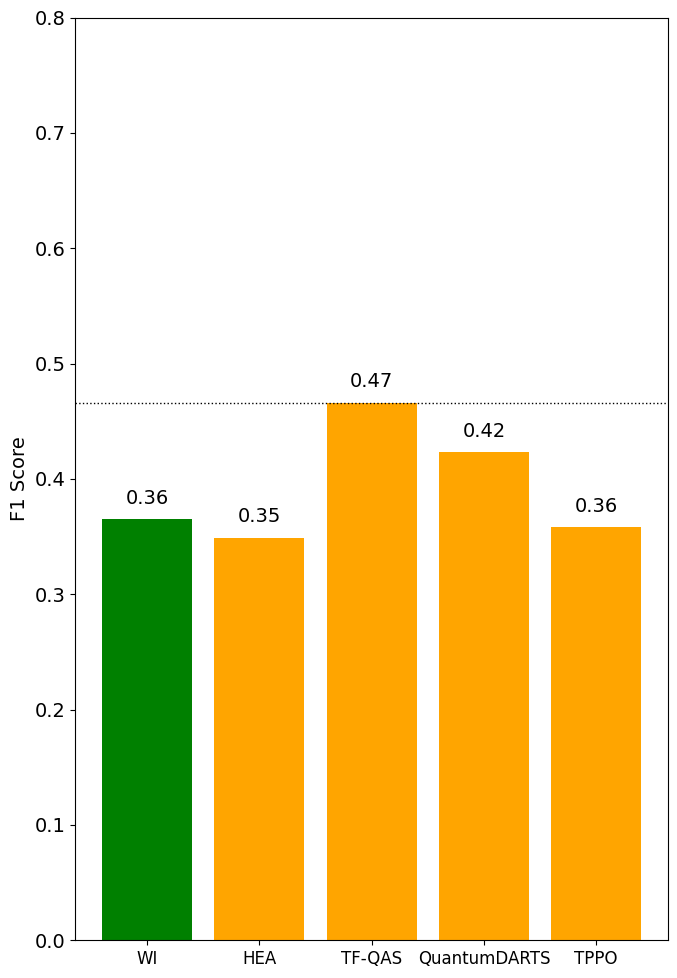

In [88]:
# F1_data = [0.649, 0.578, 0.370, 0.496, 0.309] # wine 4
# F1_data = [0.478, 0.396, 0.419, 0.523, 0.432] # wine 6
# F1_data = [0.424, 0.390, 0.419, 0.242, 0.369] # wine 8

# F1_data = [0.429, 0.407, 0.553, 0.426, 0.317] # diabetes 4
# F1_data = [0.408, 0.389, 0.462, 0.358, 0.452] # diabetes 6
F1_data = [0.365, 0.349, 0.466, 0.423, 0.358] # diabetes 8

Labels = ['WI', 'HEA', 'TF-QAS', 'QuantumDARTS', 'TPPO']
colors = ['green', 'orange', 'orange', 'orange', 'orange']

plot_F1_benchmark(F1_data, Labels, colors)